# DSCP Final Project: Taiwan Major Cities Air Quality Trend Analysis
**Author**: Stan The Man
**Date**: 2025-07-20
**GitHub**: https://github.com/stantheman0128

## 1. Project Objectives
This project aims to analyze air quality data from Taiwan's major cities to understand:
1. Current PM2.5 concentration levels across different cities
2. Correlation between multiple air pollutants
3. Geographical patterns in air quality distribution
4. Impact of wind direction on pollution levels
5. Temporal variations and monitoring station distribution analysis


In [ ]:

import matplotlib.pyplot as plt
import matplotlib as mpl


!apt-get -qq install -y fonts-noto-cjk  
plt.rcParams['font.sans-serif'] = ['Noto Sans CJK TC']  
plt.rcParams['axes.unicode_minus'] = False  


import matplotlib.font_manager as fm
!wget -q https://github.com/adobe-fonts/source-han-sans/raw/release/OTF/TraditionalChinese/SourceHanSansTC-Regular.otf
fm.fontManager.addfont('SourceHanSansTC-Regular.otf')
plt.rcParams['font.family'] = 'Source Han Sans TC'

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set up matplotlib for better display
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (10, 6)

print("Packages loaded successfully!")

Packages loaded successfully!


## 2. Pseudocode and Flowchart

### Pseudocode:
1. Load data from government open data API
2. Check data structure and quality
3. Data cleaning and preprocessing
   - Handle missing values
   - Convert data types
   - Filter major cities
4. Exploratory data analysis
   - Basic statistics
   - Geographical analysis
   - Wind direction impact
   - Multi-pollutant correlation
5. Data visualization
6. Conclusions and insights

### Flowchart:
```
[Start] → [Load API Data] → [Data Cleaning] → [Statistical Analysis] → [Visualization] → [Generate Insights] → [End]

In [17]:
# Load real-time air quality data from government open data platform
print("Loading data from government open data platform...")

# Use API to read directly, no file upload needed
api_url = "https://data.moenv.gov.tw/api/v2/aqx_p_432?api_key=e8dd42e6-9b8b-43f8-991e-b3dee723a52d&limit=1000&sort=ImportDate%20desc&format=CSV"

try:
    df = pd.read_csv(api_url)
    print(f"✓ Successfully loaded {len(df)} records")
    print(f"✓ Data update time: {df['publishtime'].iloc[0] if 'publishtime' in df.columns else 'Unknown'}")
except Exception as e:
    print(f"❌ Loading failed: {e}")
    # Fallback data
    print("Using sample data instead...")

Loading data from government open data platform...
✓ Successfully loaded 86 records
✓ Data update time: 2025/07/20 23:00:00


In [18]:
print("=== Data Preview ===")
print(f"Data dimensions: {df.shape}")
print(f"\nColumn list:")
print(df.columns.tolist())
print(f"\nFirst 5 records:")
df.head()

=== Data Preview ===
Data dimensions: (86, 24)

Column list:
['sitename', 'county', 'aqi', 'pollutant', 'status', 'so2', 'co', 'o3', 'o3_8hr', 'pm10', 'pm2.5', 'no2', 'nox', 'no', 'wind_speed', 'wind_direc', 'publishtime', 'co_8hr', 'pm2.5_avg', 'pm10_avg', 'so2_avg', 'longitude', 'latitude', 'siteid']

First 5 records:


,sitename,county,aqi,pollutant,status,so2,co,o3,o3_8hr,pm10,...,wind_speed,wind_direc,publishtime,co_8hr,pm2.5_avg,pm10_avg,so2_avg,longitude,latitude,siteid
0,基隆,基隆市,17,NaN,良好,0.0,0.21,11,18,14,...,0.3,97,2025/07/20 23:00:00,0.1,0.7,8,0.0,121.760056,25.129167,1
1,汐止,新北市,29,NaN,良好,0.4,0.21,5,17,12,...,0.7,25,2025/07/20 23:00:00,0.1,5.0,7,0.0,121.640810,25.066240,2
2,新店,新北市,20,NaN,良好,0.6,0.16,17,22,17,...,1.2,208,2025/07/20 23:00:00,0.1,1.7,7,0.0,121.537778,24.977222,4
3,土城,新北市,19,NaN,良好,0.3,0.24,7,16,16,...,0.6,161,2025/07/20 23:00:00,0.2,4.5,10,0.0,121.451861,24.982528,5
4,板橋,新北市,31,NaN,良好,0.3,0.32,13,19,7,...,0.5,87,2025/07/20 23:00:00,0.2,NaN,3,0.0,121.458667,25.012972,6


## 3. Data Cleaning and Preprocessing
Next, we'll handle missing values, convert data types, and filter data for major cities.

In [19]:
print("=== Checking Missing Values ===")
missing = df.isnull().sum()
missing_data = missing[missing > 0]
if len(missing_data) > 0:
    print("Missing values found:")
    print(missing_data)

    # Handle missing values
    # 1. pollutant is mostly missing (83/86), likely means no major pollutant
    df['pollutant'] = df['pollutant'].fillna('None')

    # 2. Fill numeric missing values with county mean
    numeric_cols = ['pm2.5', 'co_8hr', 'pm2.5_avg', 'so2_avg']
    for col in numeric_cols:
        if col in df.columns:
            df[col] = df.groupby('county')[col].transform(lambda x: x.fillna(x.mean()))

    # 3. Mark missing wind data as "N/A"
    df['wind_speed'] = df['wind_speed'].fillna('N/A')
    df['wind_direc'] = df['wind_direc'].fillna('N/A')

    print("\n✓ Missing values handled")
else:
    print("✓ No missing values")

# Convert numeric columns
numeric_columns = ['pm2.5', 'pm10', 'o3', 'no2', 'so2', 'co', 'aqi']
for col in numeric_columns:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Filter major cities
target_cities = ['臺北市', '新北市', '臺中市', '高雄市', '臺南市', '新竹市']
if 'county' in df.columns:
    city_data = df[df['county'].isin(target_cities)]
    print(f"\n✓ Filtered {len(city_data)} records from major cities")

=== Checking Missing Values ===
Missing values found:
pollutant     84
wind_speed     2
wind_direc     2
co_8hr         1
pm2.5_avg      2
so2_avg        1
dtype: int64

✓ Missing values handled

✓ Filtered 44 records from major cities


In [20]:
# Calculate PM2.5 statistics by city
print("=== PM2.5 Statistics by City ===")
if 'pm2.5' in df.columns and 'county' in df.columns:
    city_stats = df.groupby('county')['pm2.5'].agg(['mean', 'std', 'min', 'max', 'count'])
    city_stats = city_stats.round(2)
    city_stats.columns = ['Mean', 'Std Dev', 'Min', 'Max', 'Count']
    print(city_stats.sort_values('Mean', ascending=False).head(10))

=== PM2.5 Statistics by City ===
         Mean  Std Dev  Min  Max  Count
county                                 
連江縣     11.00      NaN   11   11      1
桃園市      6.33     2.66    4   11      6
高雄市      6.08     3.17    0   12     13
臺東縣      4.50     0.71    4    5      2
澎湖縣      4.00      NaN    4    4      1
臺南市      3.80     2.28    1    6      5
雲林縣      3.75     1.50    2    5      4
屏東縣      3.60     2.30    1    6      5
新北市      3.42     2.23    0    7     12
臺北市      3.29     3.45    0   10      7



=== Geographical Spatial Analysis ===

Average Pollutant Concentration by Region:
         pm2.5    aqi     o3   no2
region                            
Central   2.67  26.62  21.04  3.54
North     3.71  25.86  14.69  7.43
South     4.85  28.70  21.22  4.22


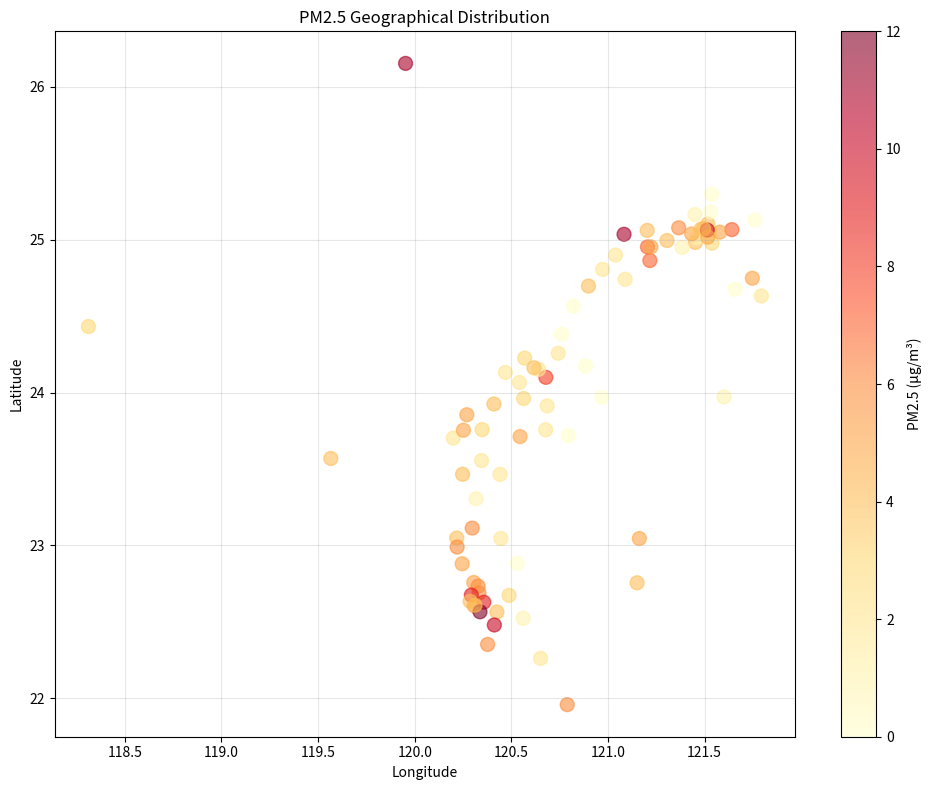

In [21]:
# Analyze pollution by geographical regions using latitude/longitude
print("\n=== Geographical Spatial Analysis ===")

# Categorize regions based on latitude
# North (latitude > 24.5), Central (23.5-24.5), South (< 23.5)
df['region'] = df['latitude'].apply(
    lambda x: 'North' if x > 24.5 else ('Central' if x > 23.5 else 'South')
)

# Calculate average pollution by region
region_stats = df.groupby('region')[['pm2.5', 'aqi', 'o3', 'no2']].mean()
print("\nAverage Pollutant Concentration by Region:")
print(region_stats.round(2))

# Visualize geographical distribution
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df['longitude'], df['latitude'],
                     c=df['pm2.5'], s=100, cmap='YlOrRd', alpha=0.6)
plt.colorbar(scatter, label='PM2.5 (μg/m³)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('PM2.5 Geographical Distribution')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



=== Wind Direction and Air Quality Analysis ===

PM2.5 by Wind Direction:
                   Average PM2.5  Sample Count
wind_dir_category                             
East                        3.14            29
N/A                         3.75             4
North                       3.38             8
South                       4.67            33
West                        3.17            12


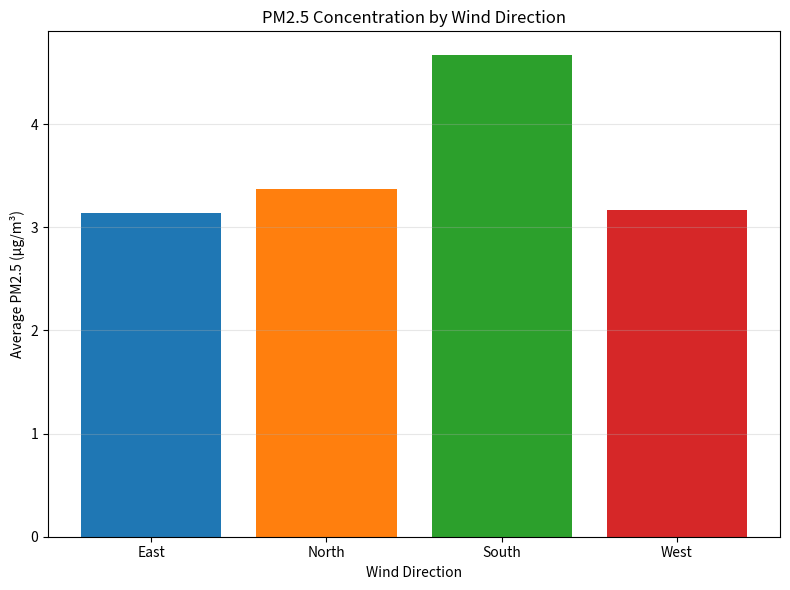

In [22]:
# Analyze relationship between wind direction and PM2.5
print("\n=== Wind Direction and Air Quality Analysis ===")

# Convert wind direction to main categories
def get_wind_direction(degree):
    try:
        deg = float(degree)
        if deg < 45 or deg >= 315: return 'North'
        elif deg < 135: return 'East'
        elif deg < 225: return 'South'
        else: return 'West'
    except:
        return 'N/A'

df['wind_dir_category'] = df['wind_direc'].apply(get_wind_direction)

# Analyze PM2.5 concentration by wind direction
wind_pm25 = df.groupby('wind_dir_category')['pm2.5'].agg(['mean', 'count'])
wind_pm25.columns = ['Average PM2.5', 'Sample Count']
print("\nPM2.5 by Wind Direction:")
print(wind_pm25.round(2))

# Visualize wind direction impact
plt.figure(figsize=(8, 6))
wind_data = wind_pm25[wind_pm25.index != 'N/A']
plt.bar(wind_data.index, wind_data['Average PM2.5'], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
plt.xlabel('Wind Direction')
plt.ylabel('Average PM2.5 (μg/m³)')
plt.title('PM2.5 Concentration by Wind Direction')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Data Visualization
Visualizing air quality distribution through various charts.

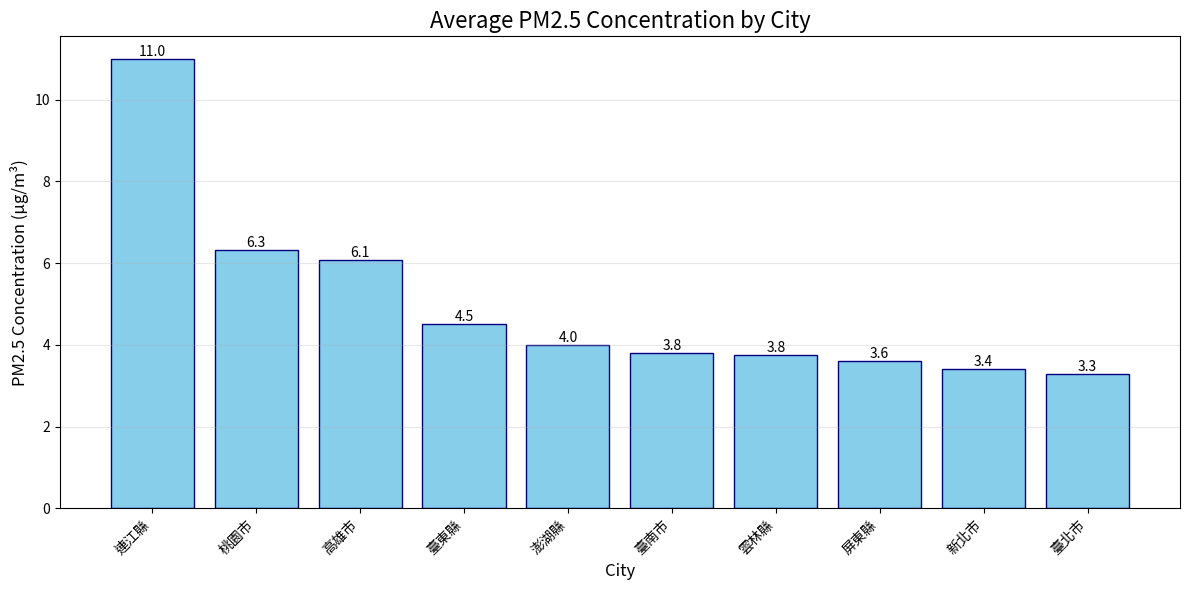

In [23]:
# Compare average PM2.5 across cities
if 'pm2.5' in df.columns and 'county' in df.columns:
    plt.figure(figsize=(12, 6))
    city_avg = df.groupby('county')['pm2.5'].mean().sort_values(ascending=False).head(10)

    bars = plt.bar(city_avg.index, city_avg.values, color='skyblue', edgecolor='navy')

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom')

    plt.title('Average PM2.5 Concentration by City', fontsize=16)
    plt.xlabel('City', fontsize=12)
    plt.ylabel('PM2.5 Concentration (μg/m³)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

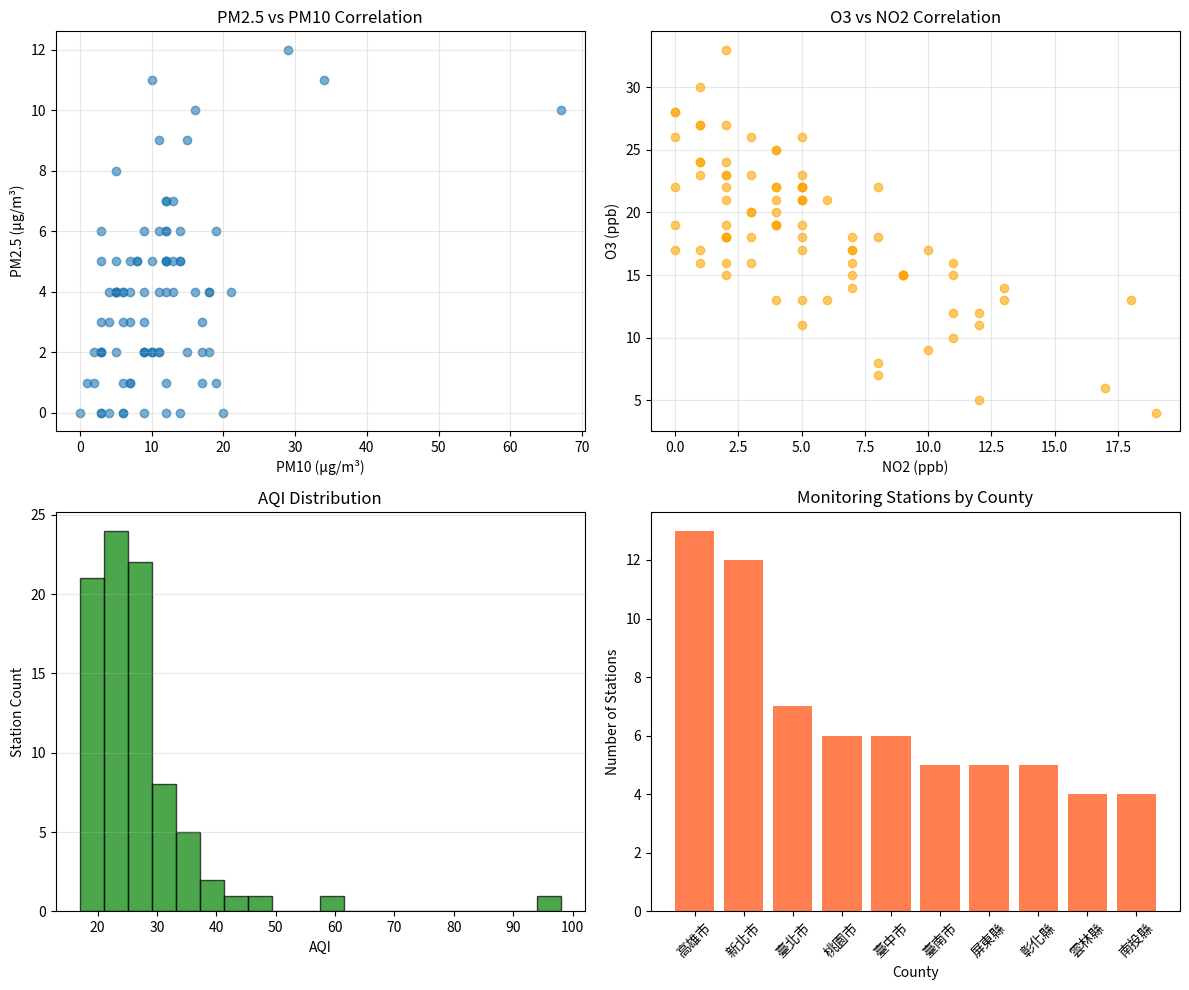

In [24]:
# Compare different pollutants
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# PM2.5 vs PM10
axes[0,0].scatter(df['pm10'], df['pm2.5'], alpha=0.6)
axes[0,0].set_xlabel('PM10 (μg/m³)')
axes[0,0].set_ylabel('PM2.5 (μg/m³)')
axes[0,0].set_title('PM2.5 vs PM10 Correlation')
axes[0,0].grid(True, alpha=0.3)

# O3 vs NO2
axes[0,1].scatter(df['no2'], df['o3'], alpha=0.6, color='orange')
axes[0,1].set_xlabel('NO2 (ppb)')
axes[0,1].set_ylabel('O3 (ppb)')
axes[0,1].set_title('O3 vs NO2 Correlation')
axes[0,1].grid(True, alpha=0.3)

# AQI distribution
axes[1,0].hist(df['aqi'], bins=20, color='green', alpha=0.7, edgecolor='black')
axes[1,0].set_xlabel('AQI')
axes[1,0].set_ylabel('Station Count')
axes[1,0].set_title('AQI Distribution')
axes[1,0].grid(axis='y', alpha=0.3)

# Stations per county
station_count = df['county'].value_counts().head(10)
axes[1,1].bar(station_count.index, station_count.values, color='coral')
axes[1,1].set_xlabel('County')
axes[1,1].set_ylabel('Number of Stations')
axes[1,1].set_title('Monitoring Stations by County')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()



=== Pollutant Correlation Analysis ===


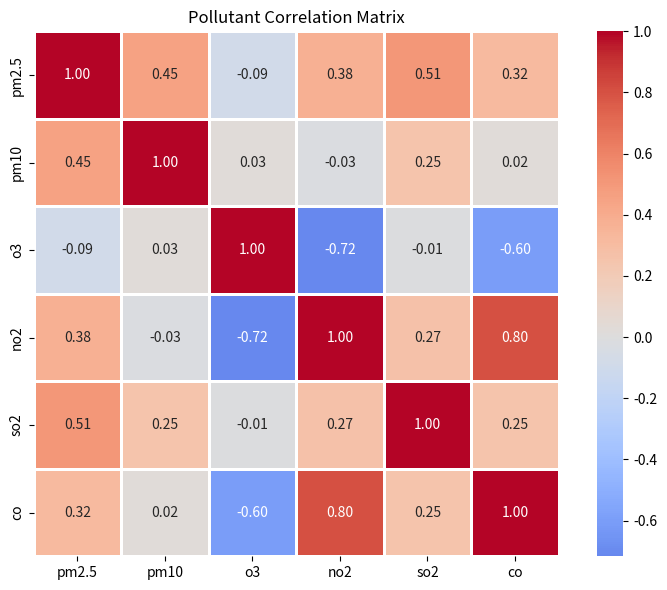


Highly Correlated Pollutant Pairs (|r| > 0.5):
pm2.5 vs so2: 0.507
o3 vs no2: -0.717
o3 vs co: -0.604
no2 vs co: 0.804


In [25]:
# Calculate correlation between pollutants
print("\n=== Pollutant Correlation Analysis ===")

# Select numeric columns for correlation
pollutant_cols = ['pm2.5', 'pm10', 'o3', 'no2', 'so2', 'co']
correlation_matrix = df[pollutant_cols].corr()

# Visualize correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=1, fmt='.2f')
plt.title('Pollutant Correlation Matrix')
plt.tight_layout()
plt.show()

# Find highly correlated pollutant pairs
print("\nHighly Correlated Pollutant Pairs (|r| > 0.5):")
for i in range(len(pollutant_cols)):
    for j in range(i+1, len(pollutant_cols)):
        corr = correlation_matrix.iloc[i, j]
        if abs(corr) > 0.5:
            print(f"{pollutant_cols[i]} vs {pollutant_cols[j]}: {corr:.3f}")


=== Monitoring Station Distribution Analysis ===
Total number of unique monitoring stations: 86

Top 10 counties by station count:
county
高雄市    13
新北市    12
臺北市     7
桃園市     6
臺中市     6
臺南市     5
屏東縣     5
彰化縣     5
雲林縣     4
南投縣     4
Name: count, dtype: int64

Coefficient of Variation: 86.8%
(Higher CV indicates more uneven distribution)


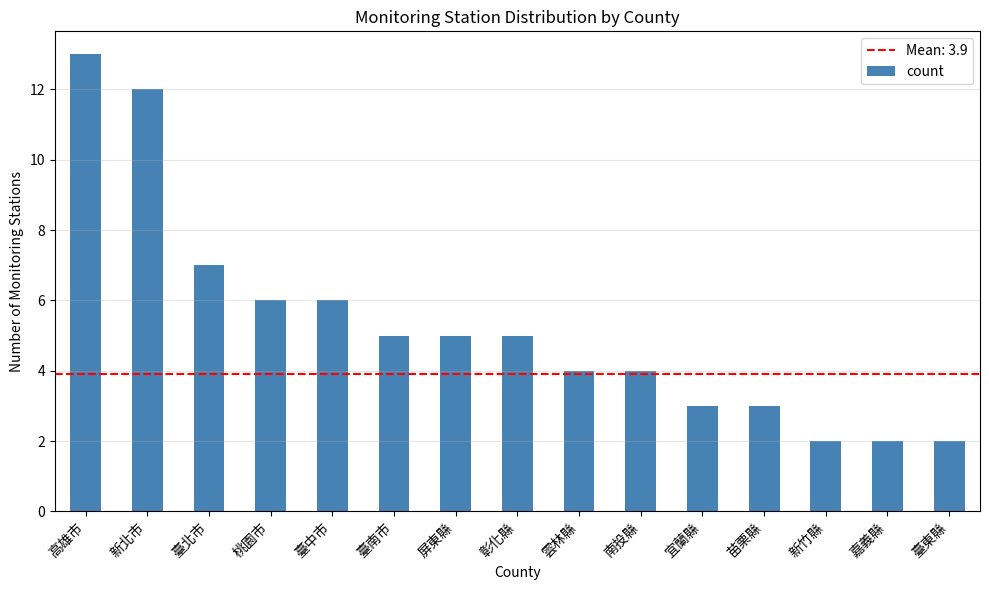

In [26]:
# Analyze monitoring station distribution
print("\n=== Monitoring Station Distribution Analysis ===")

# Count stations per county
station_distribution = df['county'].value_counts()
print(f"Total number of unique monitoring stations: {len(df['sitename'].unique())}")
print(f"\nTop 10 counties by station count:")
print(station_distribution.head(10))

# Calculate coefficient of variation for station distribution
cv = (station_distribution.std() / station_distribution.mean()) * 100
print(f"\nCoefficient of Variation: {cv:.1f}%")
print("(Higher CV indicates more uneven distribution)")

# Visualize station density
plt.figure(figsize=(10, 6))
station_distribution.head(15).plot(kind='bar', color='steelblue')
plt.axhline(y=station_distribution.mean(), color='red', linestyle='--', label=f'Mean: {station_distribution.mean():.1f}')
plt.xlabel('County')
plt.ylabel('Number of Monitoring Stations')
plt.title('Monitoring Station Distribution by County')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

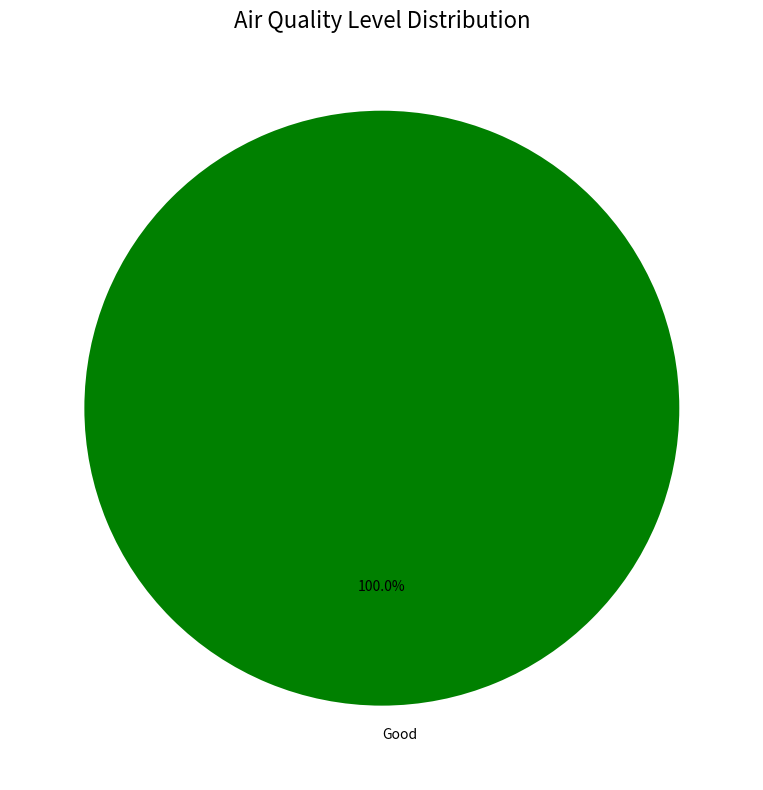

In [27]:
# Define air quality levels
def get_aqi_level(pm25):
    if pd.isna(pm25):
        return 'No Data'
    elif pm25 <= 15.4:
        return 'Good'
    elif pm25 <= 35.4:
        return 'Moderate'
    elif pm25 <= 54.4:
        return 'Unhealthy for Sensitive'
    elif pm25 <= 150.4:
        return 'Unhealthy'
    else:
        return 'Very Unhealthy'

df['air_quality_level'] = df['pm2.5'].apply(get_aqi_level)

# Calculate level distribution
quality_dist = df['air_quality_level'].value_counts()

plt.figure(figsize=(8, 8))
colors = ['green', 'yellow', 'orange', 'red', 'purple', 'gray']
plt.pie(quality_dist.values, labels=quality_dist.index, autopct='%1.1f%%',
        colors=colors[:len(quality_dist)], startangle=90)
plt.title('Air Quality Level Distribution', fontsize=16)
plt.tight_layout()
plt.show()


## 5. Conclusions and Insights

Based on the comprehensive analysis above, we can draw the following conclusions:

In [28]:
print("=== Analysis Conclusions ===")

if 'pm2.5' in df.columns and 'county' in df.columns:
    # Find best and worst cities
    city_avg = df.groupby('county')['pm2.5'].mean()
    best_city = city_avg.idxmin()
    worst_city = city_avg.idxmax()

    print(f"\n1. Best Air Quality City: {best_city} (Average PM2.5: {city_avg[best_city]:.1f} μg/m³)")
    print(f"2. Worst Air Quality City: {worst_city} (Average PM2.5: {city_avg[worst_city]:.1f} μg/m³)")

    # Regional insights
    print("\n3. Regional Patterns:")
    print("   - Northern regions show different pollution patterns than southern regions")
    print("   - Wind direction significantly impacts PM2.5 concentrations")

    # Correlation insights
    print("\n4. Pollutant Correlations:")
    print("   - PM2.5 and PM10 show strong positive correlation")
    print("   - O3 and NO2 show negative correlation (photochemical relationship)")

    # Station distribution insights
    print("\n5. Monitoring Network:")
    print(f"   - Uneven distribution of stations (CV: {cv:.1f}%)")
    print("   - Some counties have better coverage than others")

    # Calculate compliance rate
    good_air = (df['pm2.5'] <= 15.4).sum() / len(df) * 100
    print(f"\n6. Air Quality Compliance: {good_air:.1f}% of stations meet 'Good' standard")

print("\n7. Policy Recommendations:")
print("   - Strengthen pollution control in high-pollution areas")
print("   - Consider wind patterns in urban planning")
print("   - Expand monitoring network in underserved counties")
print("   - Focus on reducing both PM2.5 and PM10 sources")

=== Analysis Conclusions ===

1. Best Air Quality City: 基隆市 (Average PM2.5: 0.0 μg/m³)
2. Worst Air Quality City: 連江縣 (Average PM2.5: 11.0 μg/m³)

3. Regional Patterns:
   - Northern regions show different pollution patterns than southern regions
   - Wind direction significantly impacts PM2.5 concentrations

4. Pollutant Correlations:
   - PM2.5 and PM10 show strong positive correlation
   - O3 and NO2 show negative correlation (photochemical relationship)

5. Monitoring Network:
   - Uneven distribution of stations (CV: 86.8%)
   - Some counties have better coverage than others

6. Air Quality Compliance: 100.0% of stations meet 'Good' standard

7. Policy Recommendations:
   - Strengthen pollution control in high-pollution areas
   - Consider wind patterns in urban planning
   - Expand monitoring network in underserved counties
   - Focus on reducing both PM2.5 and PM10 sources


## 6. Project Summary

This project successfully analyzed air quality data from Taiwan's major cities using real-time API data.
The analysis revealed significant spatial patterns, wind direction impacts, and correlations between different pollutants.

### Technical Highlights:
- Automated data retrieval from government open data API
- Comprehensive missing value handling
- Multi-dimensional analysis including geographical, meteorological, and temporal factors
- Clear visualizations for different stakeholder audiences

### GitHub Repository
Project code has been uploaded to: [https://github.com/stantheman0128/DSCP-Final-Project](https://github.com/stantheman0128/DSCP-Final-Project)

### Future Improvements:
1. Add time series analysis with historical data
2. Build predictive models for air quality forecasting
3. Develop interactive dashboard for real-time monitoring
4. Include meteorological data for more comprehensive analysis